In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from eval import eval
from loss import pixel_difference_percentage

In [2]:
# flat image codes
codes = [96, 63, 98,121,177,189]

In [3]:
def read_image(code):
    # Code as 4digit string
    padded_code = str(code).zfill(4)
    # Read the image
    image_path = f"dataset/images/render/render{padded_code}.png"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    return image

def read_mask(code):
    # Code as 4digit string
    padded_code = str(code).zfill(4)
    # Read the mask
    mask_path = f"dataset/images/ground/ground{padded_code}.png"
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask not found: {mask_path}")
    
    return mask

In [4]:
def plot_image_vs_original(image, original):
    """
    Plots the segmented image against the original image
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Segmented Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.show()

In [5]:
def fourier_remove_low_freq(image, mask):
    """
    Returns an image with low frequency components removed
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    phase_spectrum = np.angle(fshift)
    
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    radius = 50
    mask = np.ones((rows, cols), dtype=np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 0, -1)

    fshift = fshift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = np.uint8(img_back)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    return img_back



In [6]:
def opening(image, kernel_size=(5, 5), element=cv2.MORPH_ELLIPSE):
    """
    Applies morphological opening to the image
    """
    kernel = cv2.getStructuringElement(element, kernel_size)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opened_image

def closing(image, kernel_size=(5, 5), element=cv2.MORPH_ELLIPSE):
    """
    Applies morphological closing to the image
    """
    kernel = cv2.getStructuringElement(element, kernel_size)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closed_image

In [7]:
def umbralize(image, threshold=50):
    """
    Applies binary thresholding to the image
    """
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

In [8]:
def kmeans_segmentation(image, k=2):
    """
    Applies k-means segmentation to the image
    """
    Z = image.reshape((-1, 1))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmented_image = centers[labels.flatten()].reshape(image.shape).astype(np.uint8)
    return segmented_image

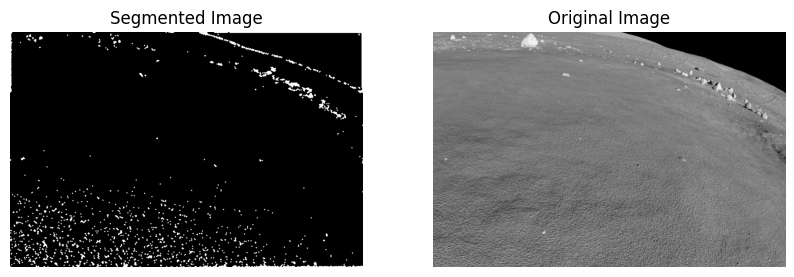

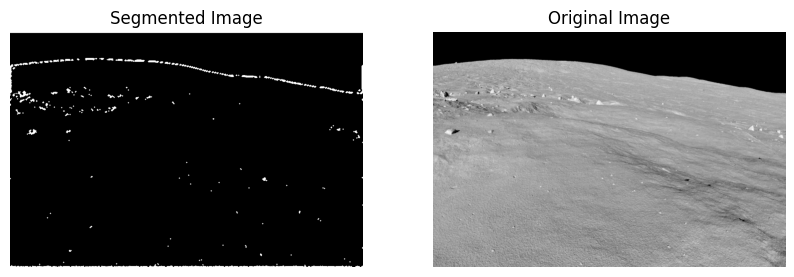

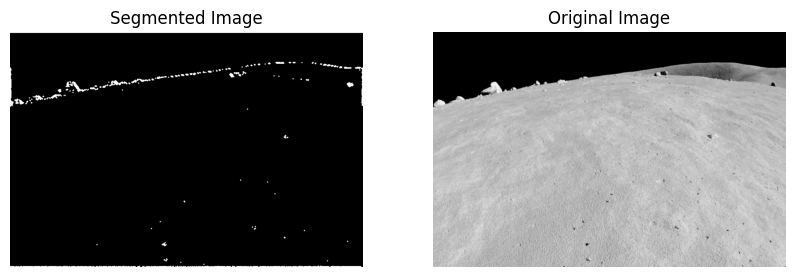

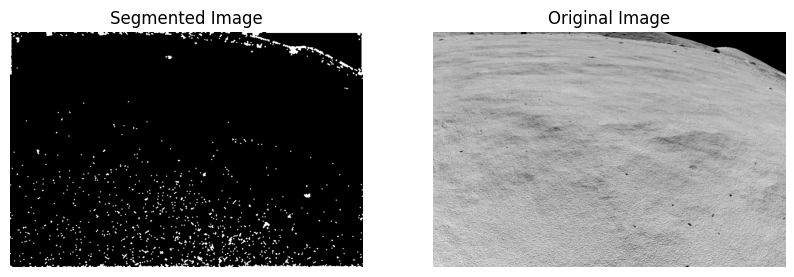

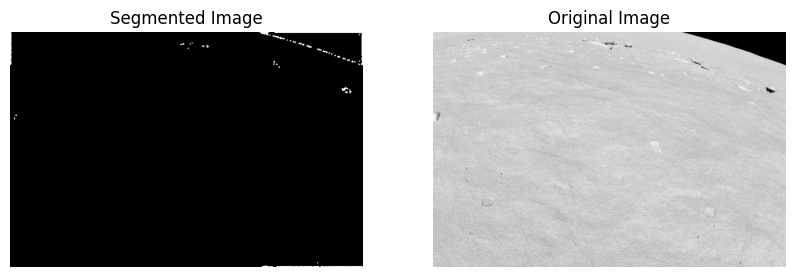

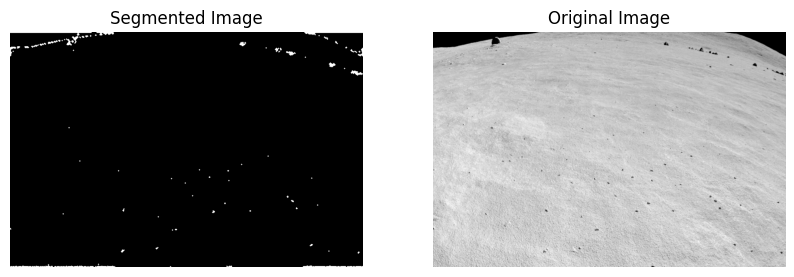

In [16]:
def segment(image):
    """
    Returns a mask of an image
    """
    mask = np.zeros(image.shape, dtype=bool)
    for code in codes:
        mask |= (image == code)
    mask = np.invert(mask)
    mask = fourier_remove_low_freq(image, mask)
    
    edges = cv2.Canny(mask, 50, 150, apertureSize=3)
    img_width = image.shape[1]
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=80,
                            minLineLength=img_width // 4, maxLineGap=img_width // 10) 
    
    # if lines is not None:
    #     for line in lines:
    #         x1, y1, x2, y2 = line[0]
    #         # Filter for predominantly horizontal lines (e.g., angle < 15 degrees or > 165 degrees)
    #         angle = np.rad2deg(np.arctan2(y2 - y1, x2 - x1))
    #         if abs(angle) < 15 or abs(angle) > 165 : # Checks for horizontal-ish lines
    #             # Remove the detected line by drawing over it with 0 (background)
    #             # The thickness should be enough to cover the highlighted line.
    #             cv2.line(mask, (x1, y1), (x2, y2), 0, thickness=5) # Adjust thickness as needed
    
    mask = kmeans_segmentation(mask, k=2)
    # mask = np.clip(mask, 0, 255).astype(np.uint8)
    
    mask = opening(mask, kernel_size=(3, 3))
    mask = closing(mask, kernel_size=(3, 3))
    # mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX)
    mask = umbralize(mask, threshold=10)

    return mask

for code in codes:
    image = read_image(code)
    original = image.copy()
    segmented_image = segment(image)
    plot_image_vs_original(segmented_image, original)

## show histogram of segmented image

In [13]:
losses = [eval(str(code).zfill(4), segment) for code in range(1,200)]

print("Losses:", losses)
print('avg', np.mean(losses))

print("Processing complete.")

Losses: [30.067997685185183, 7.079282407407407, 21.639756944444443, 25.869502314814813, 14.159722222222223, 13.433449074074074, 44.52893518518518, 18.92534722222222, 4.265625, 34.20543981481482, 35.94386574074074, 38.26649305555556, 43.317708333333336, 25.773148148148152, 50.31394675925925, 38.00694444444444, 40.629050925925924, 12.268229166666666, 36.1015625, 9.962962962962962, 23.990162037037038, 29.701388888888893, 16.673900462962962, 35.0853587962963, 2.4068287037037037, 33.39554398148148, 31.941261574074076, 39.06105324074074, 41.237557870370374, 36.10966435185185, 52.45862268518518, 40.50925925925926, 45.7818287037037, 22.82060185185185, 13.089699074074074, 27.406828703703706, 6.614583333333333, 40.37413194444445, 31.96440972222222, 32.38917824074074, 45.179398148148145, 39.01417824074074, 16.32696759259259, 46.423611111111114, 29.47048611111111, 84.61631944444444, 26.555266203703702, 28.36603009259259, 48.48061342592593, 14.103298611111112, 29.976273148148145, 30.47800925925926,

In [14]:
print('std: ', np.std(losses))
print('min: ', np.min(losses))
print('max: ', np.max(losses))
print('median: ', np.median(losses))

std:  13.92659276064269
min:  2.4068287037037037
max:  84.61631944444444
median:  28.802951388888886
